# Background


This notebook is to make a baseline for slot1, aspect category detection. We use glove to generate sentence vector. 

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

In [9]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/train.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/test.csv')

In [10]:
# Read data
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [11]:
def df2data(df):
    """Read data and labels from dataframe
    Input:
        df: three columns, ['Sentence #', 'Tag', 'Word']
    Output:
        data: datasize * ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
        label: datasize * ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
    """
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                 s["Tag"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    data = [[w[0] for w in s] for s in grouped]
    label = [[w[1] for w in s] for s in grouped]  
    
    return data, label

In [12]:
x_train_words, _ = df2data(data_train)
x_test_words, _ = df2data(data_test)

### embedding 

In [17]:
import tqdm
import numpy as np

def load_glove(file):
    """Loads GloVe vectors in numpy array.
    Args:
        file (str): a path to a glove file.
    Return:
        dict: a dict of numpy arrays.
    """
    embeddings_index = {}
    with open(file, encoding='utf8') as f:
        for i, line in enumerate(f):
            values = line.split()
            word = ''.join(values[:-300])
            coefs = np.asarray(values[-300:], dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

In [18]:
EMBEDDING_PATH = '../embedding_weights/glove.840B.300d.txt'

In [19]:
embeddings = load_glove(EMBEDDING_PATH)

No need to padding

In [22]:
def words2vector(x_words, vector_size=200):

    sentence_vectors = []
    no_word_match = 0

    for sent in x_words:
        vector = []
        for word in sent:
            if embeddings.get(word) is not None:
                vector.append(embeddings[word])
        if len(vector) > 0:
            sentence_vectors.append(np.mean(vector, axis=0))
        else:
            sentence_vectors.append(np.array([0] * vector_size))
            no_word_match += 1

    if no_word_match > 0:
        print("{} sentences does not match any pretrained vector.".format(no_word_match))

    return np.array(sentence_vectors)

In [41]:
x_train = words2vector(x_train_words, vector_size=300)
x_test = words2vector(x_test_words, vector_size=300)

1 sentences does not match any pretrained vector.


In [25]:
print(len(x_train))
print(len(x_test))

2000
676


### label 

Read label from csv file. this is a multicalss classification

In [26]:
train_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/train_label_df.csv')
test_path = Path.cwd().parent.joinpath('datasets/semeval-2016/slot1/test_label_df.csv')

In [27]:
y_train_df = pd.read_csv(train_path)
y_test_df = pd.read_csv(test_path)

In [30]:
y_train_df.head(3)

,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,1


# model construct

In [42]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

%matplotlib inline

# learning curve function
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(
        estimator, title, X, y, ylim=None, cv=None,
        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[learning_curve] Training set sizes: [ 160  520  880 1240 1600]
[CV]  ................................................................
[CV] .................................... , score=0.335, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ................................... , score=0.4275, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4575, total=   0.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s


[CV] ..................................... , score=0.47, total=   0.6s
[CV]  ................................................................
[CV] ................................... , score=0.5025, total=   0.7s
[CV]  ................................................................
[CV] .................................... , score=0.325, total=   0.1s
[CV]  ................................................................
[CV] ................................... , score=0.4075, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4325, total=   0.4s
[CV]  ................................................................
[CV] .................................... , score=0.455, total=   0.5s
[CV]  ................................................................
[CV] ................................... , score=0.4425, total=   0.8s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))


[CV] ................................... , score=0.4225, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4275, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=0.4425, total=   0.6s
[CV]  ................................................................
[CV] .................................... , score=0.445, total=   0.7s
[CV]  ................................................................
[CV] ................................... , score=0.3325, total=   0.1s
[CV]  ................................................................
[CV] ...................................... , score=0.4, total=   0.2s
[CV]  ................................................................
[CV] ..................................... , score=0.44, total=   0.4s
[CV]  ................................................................
[CV] .

/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


[CV] ................................... , score=0.3675, total=   0.2s
[CV]  ................................................................
[CV] ................................... , score=0.4025, total=   0.4s
[CV]  ................................................................
[CV] ................................... , score=0.4325, total=   0.6s
[CV]  ................................................................
[CV] ................................... , score=0.4225, total=   0.7s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.7s finished


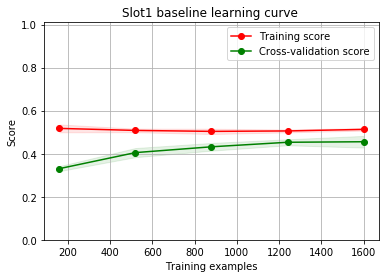

In [43]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit


cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ovr = OneVsRestClassifier(LogisticRegression())

plot_learning_curve(ovr, "Slot1 baseline learning curve ",
                    x_train, y_train_df, ylim=(0.0, 1.01), cv=cv, n_jobs=1, verbose=4)

plt.show()

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


ovr = OneVsRestClassifier(LogisticRegression())
ovr.fit(x_train, y_train_df)

predicted = ovr.predict(x_test)
f1_score(y_test_df, predicted, average="micro")

0.6220095693779905

- `glove.6B.200d.txt`: 0.594
- `glove.840B.300d.txt`: 0.622